# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

In [57]:
# torch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

# sklearn and skorch modules
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from skorch import NeuralNetRegressor,NeuralNetClassifier,callbacks
from skorch.dataset import CVSplit

# various modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Regression task

## Dataset

In [58]:
class CsvDataset(Dataset):

    def __init__(self, csv_file):
        """
        Parameters:
            csv_file (string): Path to the csv file.

        """
        # store file inside pandas object
        self.data = torch.tensor(pd.read_csv(csv_file).to_numpy(),dtype=torch.float32)

    def __len__(self):
        # data length
        return len(self.data)

    def __getitem__(self, idx):
        # our sample is the element idx of the list self.data
        return self.data[idx]

In [59]:
train_dataset = CsvDataset('regression_dataset/train_data.csv')
test_dataset = CsvDataset('regression_dataset/test_data.csv')

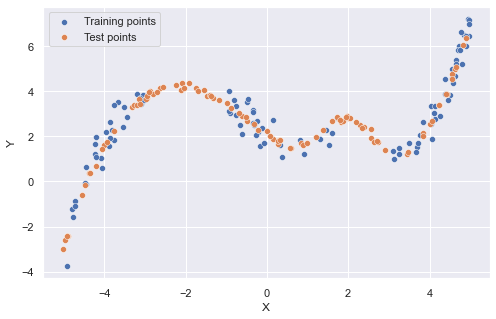

In [60]:
fig = plt.figure(figsize=(8,5))
sns.scatterplot(x=train_dataset[:,0], y=train_dataset[:,1], label='Training points')
sns.scatterplot(x=test_dataset[:,0], y=test_dataset[:,1], label='Test points')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## Network definition

In [61]:
class Net(nn.Module):
    """
    Network with customizable set of hidden layers

    """
    def __init__(self, N_in=1, N_hid=[10], N_out=1, act_func = nn.Sigmoid(), dropout = 0, act_output = False):
        """
        Initialization function for the network
        
        Parameters
        ----------
        
        N_in: Input layer size
        N_hid: Array containing sizes of hidden layers
        N_out: Output layer size
        act_func: Activation function
        dropout: Activate dropout between hidden layers
        act_output: Activation function on the output
        
        """
        super(Net,self).__init__()
        
        # defining internal variables
        self.N_in=N_in                # number of input neurons  
        self.N_hid=N_hid              # sizes of hidden layers
        self.N_out=N_out              # size of output layer  
        self.act_func = act_func      # activation function 
        self.dropout = dropout        # dropout value  
        self.act_output = act_output  # boolean for activation function on the output neuron  
        
        self.hid_layers = []
        self.hid_layers.append(nn.Linear(in_features=N_in, out_features=N_hid[0]))

        # appending hidden layers 
        for i in range(1,len(N_hid)):
            self.hid_layers.append(nn.Linear(in_features=N_hid[i-1], out_features=N_hid[i]))
        
        # creating output layer
        self.out_layer = nn.Linear(in_features=N_hid[-1], out_features=N_out)
            
    def forward(self, x):
        # forward calculations of layers output
        for layer in self.hid_layers:
            x = self.act_func(layer(x))
            if self.dropout>0:
                x = nn.Dropout(self.dropout)(x)

        x = self.out_layer(x)
        
        if self.act_output == True:
            x = self.act_func(x)
        return x

## Network initialization

In [62]:
# instantiating the network and wrapping with the NeuralNetRegressor object of skorch to 
torch.manual_seed(0)
network = Net(N_in=1,           
            N_hid=[167, 32, 187], 
            N_out=1,            
            dropout=0,          
            act_func=nn.ReLU(), 
            act_output=False,)  

net_skorch = NeuralNetRegressor(
            module=network,         
            criterion= nn.MSELoss,                                      # loss function
            max_epochs=10000,                                           # maximum training epochs
            optimizer__lr = 0.1,                                        # learning rate
            optimizer = optim.Adam,                                     # optimizer
            batch_size = 100,                                           # batch_size
            callbacks = [callbacks.EarlyStopping(monitor='valid_loss',  # early stopping callback
                             patience=100, threshold=0.1)],
            verbose=0,
           # device='cuda',  # uncomment this to train with CUDA
)

## Training

In [63]:
net_skorch.fit(train_dataset[:,0].reshape([-1,1]), train_dataset[:,1].reshape([-1,1]))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (act_func): ReLU()
    (out_layer): Linear(in_features=187, out_features=1, bias=True)
  ),
)

## Loss plot

In [64]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

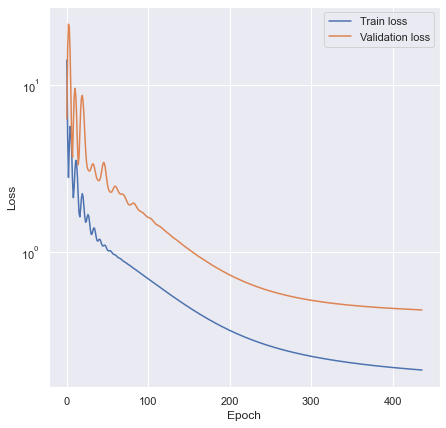

In [65]:
# losses plot
f, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=np.arange(len(train_loss)),y=train_loss, label='Train loss', markers=True,  ax=ax)
sns.lineplot(x=np.arange(len(train_loss)),y=val_loss, label='Validation loss',markers=True, ax=ax)

ax.set_yscale("log")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results

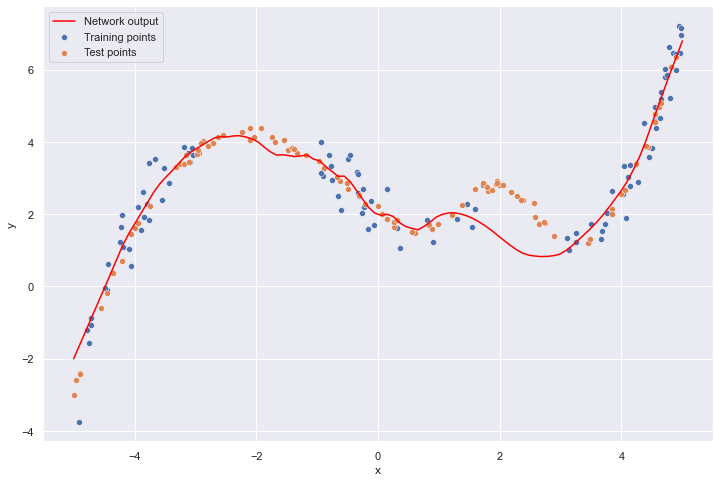

In [66]:
# convert x_vec and y_vec to numpy one dimensional arrays
x_vec = torch.tensor(np.linspace(5,-5,100).reshape(-1,1),dtype=torch.float32)
y_vec = net_skorch.predict(x_vec)

# plot output
plt.figure(figsize=(12,8))
sns.lineplot(x=np.linspace(5,-5,100), y=y_vec.flatten(), label='Network output', color="Red")
sns.scatterplot(x=train_dataset[:,0], y=train_dataset[:,1], label='Training points')
sns.scatterplot(x=test_dataset[:,0], y=test_dataset[:,1], label='Test points')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [67]:
# calculation of the test loss
net_skorch.get_loss(torch.tensor(net_skorch.predict(test_dataset[:,0].reshape(-1,1)).flatten()),test_dataset[:,1])

tensor(0.3827)

## Layer activations

In [68]:
# adding a hook to record activations
activations = []

def activation_hook(module, input, output):
    activations.append(output.detach())

# adding a hook for each layer
for layer in network.hid_layers:
    layer.register_forward_hook(activation_hook)

network.out_layer.register_forward_hook(activation_hook)

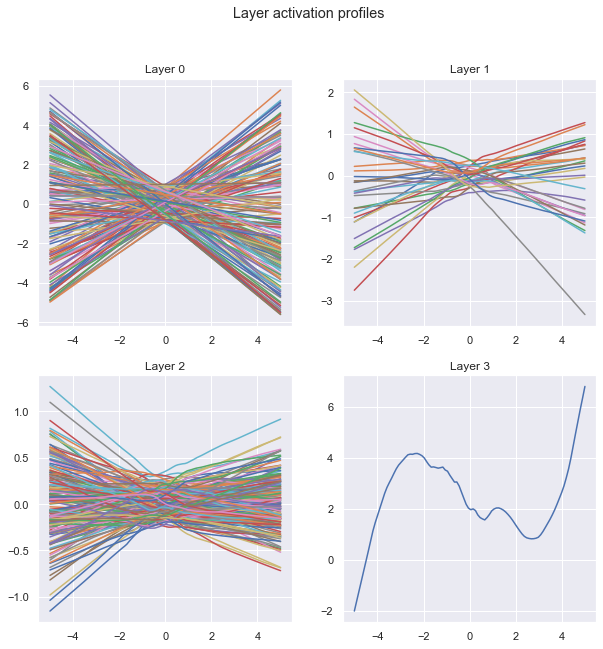

In [69]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
network(x_vec.clone().detach().unsqueeze(1))
plt.suptitle("Layer activation profiles")
for i,act,ax in zip(np.arange(4),activations,axes.flatten()):
    ax.plot(x_vec,act.reshape(act.shape[0],act.shape[2]))
    ax.set_title(f"Layer {i}")


## Weights visualization

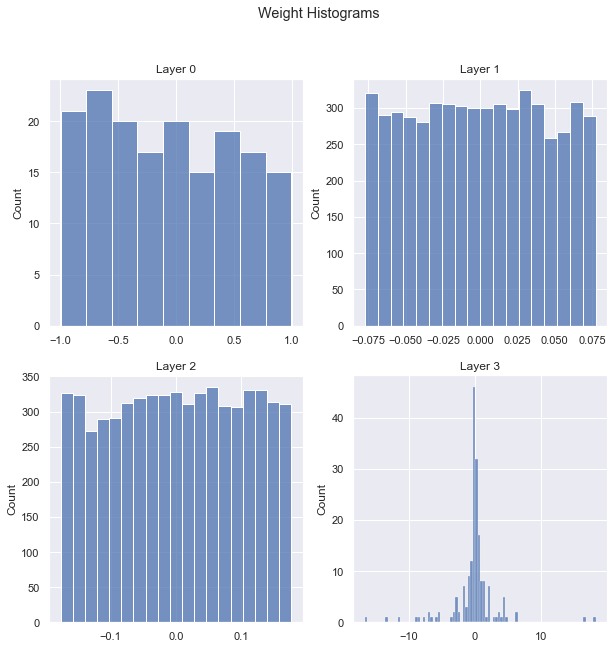

In [70]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
plt.suptitle("Weight Histograms")
layer_list = network.hid_layers.copy()
layer_list.append(network.out_layer)

for i,layer,ax in zip(np.arange(4),layer_list,axes.flatten()):
    # expanding the layers content in order to plot the weights
    sns.histplot(layer.weight.detach().numpy().flatten(),ax=ax)
    ax.set_title(f"Layer {i}")

## GridSearch

In this section a GridSearch approach for parameter estimation was applied
 

In [71]:
# params = {
#     'optimizer__lr': np.arange(0.001,1,0.009),
#     'module__N_hid' : [[i,j,k] for i in np.arange(2,200,5) for j in np.arange(2,200,5) for k in np.arange(2,200,5)],

# }

# rs = RandomizedSearchCV(estimator = net_skorch, 
#                    param_distributions = params, 
#                    cv = KFold(n_splits=5,shuffle=True), n_iter = 10000)
# rs.fit(train_dataset[:,0].reshape([-1,1]), train_dataset[:,1].reshape([-1,1]))
# print(rs.best_score_, rs.best_params_)

In [72]:
## Gridsearch result for plotting

# pd.DataFrame(rs.cv_results_).to_csv("Random_Regression.csv")
df = pd.read_csv("Random_Regression.csv").sort_values("mean_test_score")
df[df["std_test_score"]<0.025].tail(5)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__lr,param_module__N_hid,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6049,6049,0.257316,0.030207,0.0006,0.000200,0.883,"[57, 42, 187]","{'optimizer__lr': 0.8829999999999998, 'module_...",-0.031617,0.018894,0.011999,0.030006,-0.026570,0.000543,0.024922,36
133,133,0.242501,0.020552,0.0007,0.000245,0.892,"[2, 87, 197]","{'optimizer__lr': 0.8919999999999998, 'module_...",-0.041323,-0.001924,0.020511,0.028267,-0.002190,0.000669,0.024222,34
284,284,0.263901,0.004247,0.0006,0.000200,0.964,"[112, 147, 182]","{'optimizer__lr': 0.9639999999999997, 'module_...",-0.030749,0.016722,0.016441,0.023777,-0.021078,0.001023,0.022360,29
2891,2891,0.220900,0.012769,0.0007,0.000245,0.307,"[17, 2, 157]","{'optimizer__lr': 0.30699999999999994, 'module...",0.000437,0.022026,0.010107,0.005679,-0.032874,0.001075,0.018410,28
6728,6728,0.237909,0.002764,0.0007,0.000245,0.937,"[167, 32, 187]","{'optimizer__lr': 0.9369999999999997, 'module_...",-0.031140,0.018363,0.014906,0.029507,-0.015153,0.003297,0.022694,20


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [73]:
# creating the transformations list
transformations = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=15, translate=(.05, .05), scale=(0.95,1.05)) ])

# loading train and test dataset
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transformations)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

# defining input and label dataset for training
input_data = train_dataset.data.type(torch.float32).reshape(60000,1,28,28)
label_data = train_dataset.targets.type(torch.int64).reshape(60000)

test_input_data = test_dataset.data.type(torch.float32).reshape(10000,1,28,28)
test_label_data = test_dataset.targets.type(torch.int64).reshape(10000)

## Models definition

In [74]:
class ConvolutionalNet(nn.Module):
    """
    Network with customizable set of hidden layers
    """
    def __init__(self,  dropout=0, act_func=nn.ReLU(), linear_size = 100, conv0_size = 10, conv1_size = 20):
        """
        Initialization function for the network
        
        Parameters
        ----------
        dropout: dropout probability for the function applied after the second convolutional layer
        act_func: activation function for the convolutional layers 
        linear_size: size of the linear layer of the model
        conv0_size: number of channels of the first convolutional layer
        conv1_size: number of channels of the second convolutional layer

        """
        super(ConvolutionalNet,self).__init__()
        
        # first layer settings
        self.kernel_size0 = 2
        self.padding0 = 1
        self.stride0 = 2
        self.dilation0 = 1

        # second layer settings
        self.kernel_size1 = 3
        self.padding1 = 1
        self.stride1 = 2
        self.dilation1 = 1

        # linear layer settings        
        self.linear_size = linear_size
        self.conv0_size = conv0_size
        self.conv1_size = conv1_size     
        self.act_func = act_func
        self.final_func = nn.Softmax(dim=1)
        self.N_out= 10

        # dropout settings
        self.dropout = dropout
        self.dropout_func = nn.Dropout(self.dropout)

        # network instantiation
        self.conv0 = nn.Conv2d(1,self.conv0_size,kernel_size=self.kernel_size0,padding=self.padding0,stride=self.stride0,dilation=self.dilation0) #(1,28,28) -> (self.conv0_size,15,15)
        
        self.conv1 = nn.Conv2d(self.conv0_size,self.conv1_size,kernel_size=self.kernel_size1,padding=self.padding1,stride=self.stride1,dilation=self.dilation1) #(self.conv0_size,15,15) -> (self.conv1_size,8,8)

        self.lin_layer = nn.Linear(in_features=self.conv1_size*8*8, out_features=self.linear_size)          
        self.out_layer = nn.Linear(in_features=self.linear_size, out_features=self.N_out)
        
    def forward(self, x):
        
        # first convolutional layer
        x = self.conv0(x)
        x = self.act_func(x)

        # second convolutional layer  
        x = self.conv1(x)
        x = self.act_func(x)

        # dropout function
        x = self.dropout_func(x)

        # linear layer
        x = x.view(-1,self.conv1_size*8*8)
        x = self.lin_layer(x)
        x = self.act_func(x)

        # output layer
        x = self.out_layer(x)
        
        x = self.final_func(x)
        return x

## Model implementation

In [75]:
torch.manual_seed(0)
classifierNet = ConvolutionalNet(act_func=nn.ReLU(), linear_size=120, conv0_size = 10, conv1_size = 20, dropout=0.2)

net_skorch = NeuralNetClassifier(
            module=classifierNet,   
            criterion= nn.CrossEntropyLoss,                             # loss calculation function
            max_epochs=20,                                              # max number of epochs
            optimizer__lr = 1e-3,                                       # learning rate
            optimizer = optim.Adam,                                     # optimizer 
            batch_size = 1000,                                          # batch size
            # optimizer__weight_decay=0.01, # L2 Regularization          
            # device='cuda', 
            callbacks = [callbacks.EarlyStopping(monitor='valid_loss',  # callback for early stopping   
                                 patience=100, threshold=0.005)],     
            verbose = 0
)

## Notes

A kernel dilation is negleted since it would reduce consistently the output size. Linear layer size also seems to return good results if it corresponds to the current convolutional layer size. Padding 1 has been observed to be the best value for the first layer. With some values the learning seems to be stuck. Also large values of kernel size seems to be very inefficient during training.

Max Pooling doesn't seems to help much. Up to now the best architecture is built as two convolutional layer and a linear one

The channel size of the first convolutional layer seems to be smaller than the second one in order to get the best results

A larger linear size seems also to improve the result

Dropout seems not to be influent on the result before the linear layers, while L2 regularization seems not to improve results

Transformations random seems not to have much results on stability and result quality

Linear layer size also helps convergence to good results

## Model fitting

In [76]:
net_skorch.fit(input_data,label_data)

Re-initializing module because the following parameters were re-set: act_func.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9346       0.5721        1.8879  6.1398
      2        1.8862       0.5766        1.8824  6.1888
      3        1.8558       0.6630        1.7969  6.8615
      4        1.7452       0.7369        1.7242  6.6893
      5        1.7215       0.7436        1.7178  6.1958
      6        1.7135       0.7448        1.7166  6.4966
      7        1.7110       0.7442        1.7170  6.6089
      8        1.6719       0.8057        1.6542  9.1644
      9        1.6404       0.8146        1.6463  6.8584
     10        1.5978       0.8789        1.5826  8.7059
     11        1.5685       0.8770        1.5840  9.2420
     12        1.5616       0.8802        1.5802  7.3012
     13        1.5548       0.8828        1.5788  5.8111
     14        1.5529       0.8787        1.5824  5.9303
     15  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvolutionalNet(
    (act_func): ReLU()
    (final_func): Softmax(dim=1)
    (dropout_func): Dropout(p=0, inplace=False)
    (conv0): Conv2d(1, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (conv1): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (lin_layer): Linear(in_features=1280, out_features=100, bias=True)
    (out_layer): Linear(in_features=100, out_features=10, bias=True)
  ),
)

## Loss plotting

In [77]:
train_loss = net_skorch.history[:, 'train_loss']
val_loss = net_skorch.history[:, 'valid_loss']

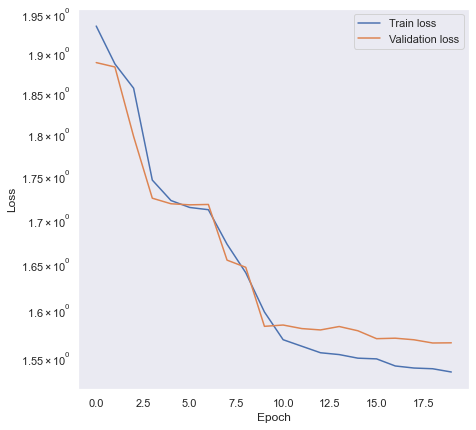

In [78]:
# Plot losses
f, ax = plt.subplots(figsize=(7, 7))
sns.lineplot(x=np.arange(len(train_loss)),y=train_loss, label='Train loss', markers=True,  ax=ax)
sns.lineplot(x=np.arange(len(train_loss)),y=val_loss, label='Validation loss',markers=True, ax=ax)

ax.set_yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Confusion Matrix

In [79]:
# estimating the prediction of the network
y_pred = net_skorch.predict(test_input_data)

<AxesSubplot:>

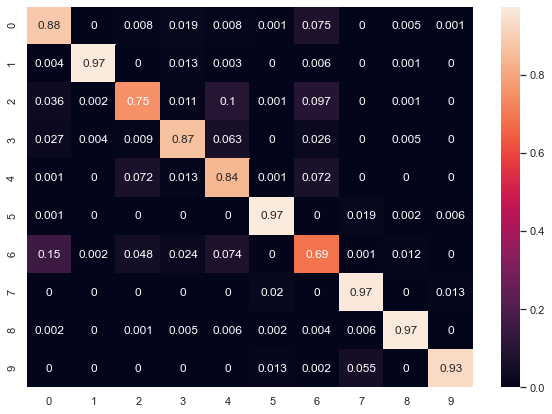

In [80]:
# plotting the confusion matrix for the prediction
plt.figure(figsize = (10,7))
c_matrix = confusion_matrix(test_label_data.detach().numpy(),y_pred)
sns.heatmap(c_matrix/c_matrix.astype(float).sum(axis=1) ,annot=True)

In [87]:
# single class accuracies
print("Accuracies for the 10 classes: ", c_matrix.diagonal()/c_matrix.sum(axis=1))
# total accuracy
print(f"Total accuracy: {(c_matrix.diagonal()/c_matrix.sum(axis=1)).mean():.2f}")

Accuracies for the 10 classes:  [0.883 0.973 0.751 0.866 0.841 0.972 0.685 0.967 0.974 0.93 ]
Total accuracy: 0.88


## Weight visualization

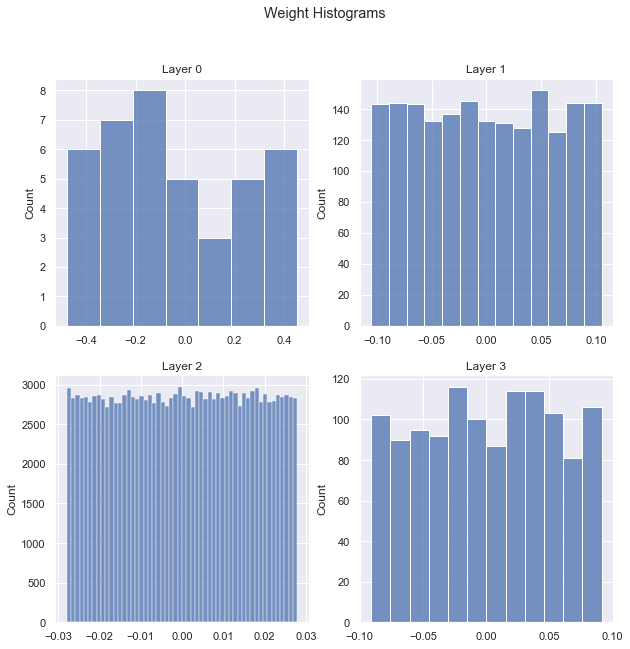

In [82]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
layers = [classifierNet.conv0,classifierNet.conv1,classifierNet.lin_layer,classifierNet.out_layer]
plt.suptitle("Weight Histograms")

for i,layer,ax in zip(np.arange(4),layers,axes.flatten()):
    sns.histplot(layer.weight.detach().numpy().flatten(), ax=ax)
    ax.set_title(f"Layer {i}")

## Feature Maps

In this section it is possible to plot feature maps for different input images

In [104]:
no_of_layers=2
conv_layers=list(classifierNet.children())[3:5]

image = input_data[[10]]

results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


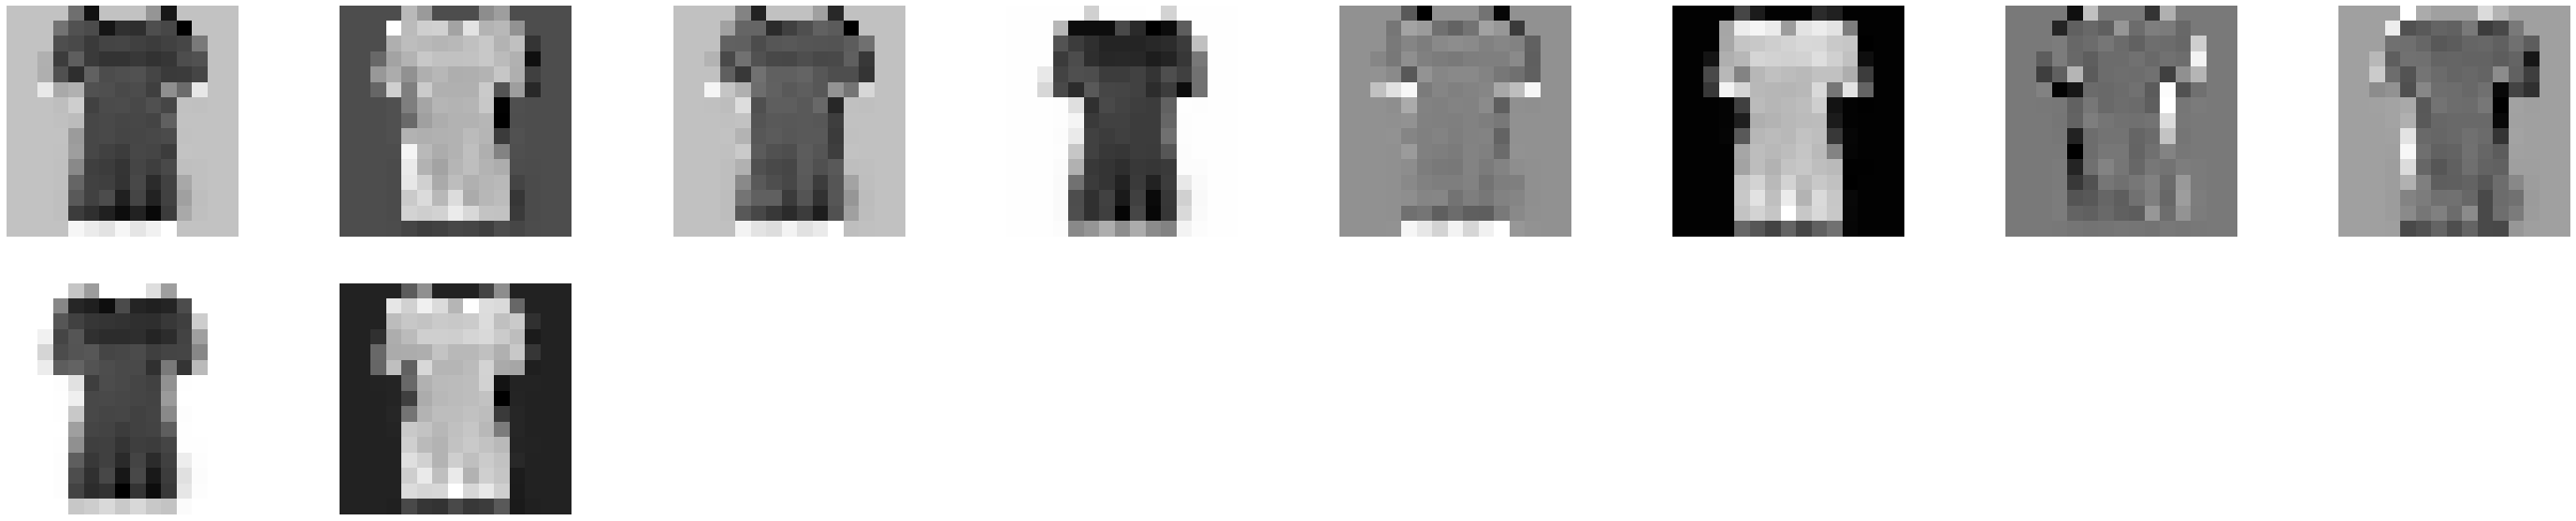

Layer  2


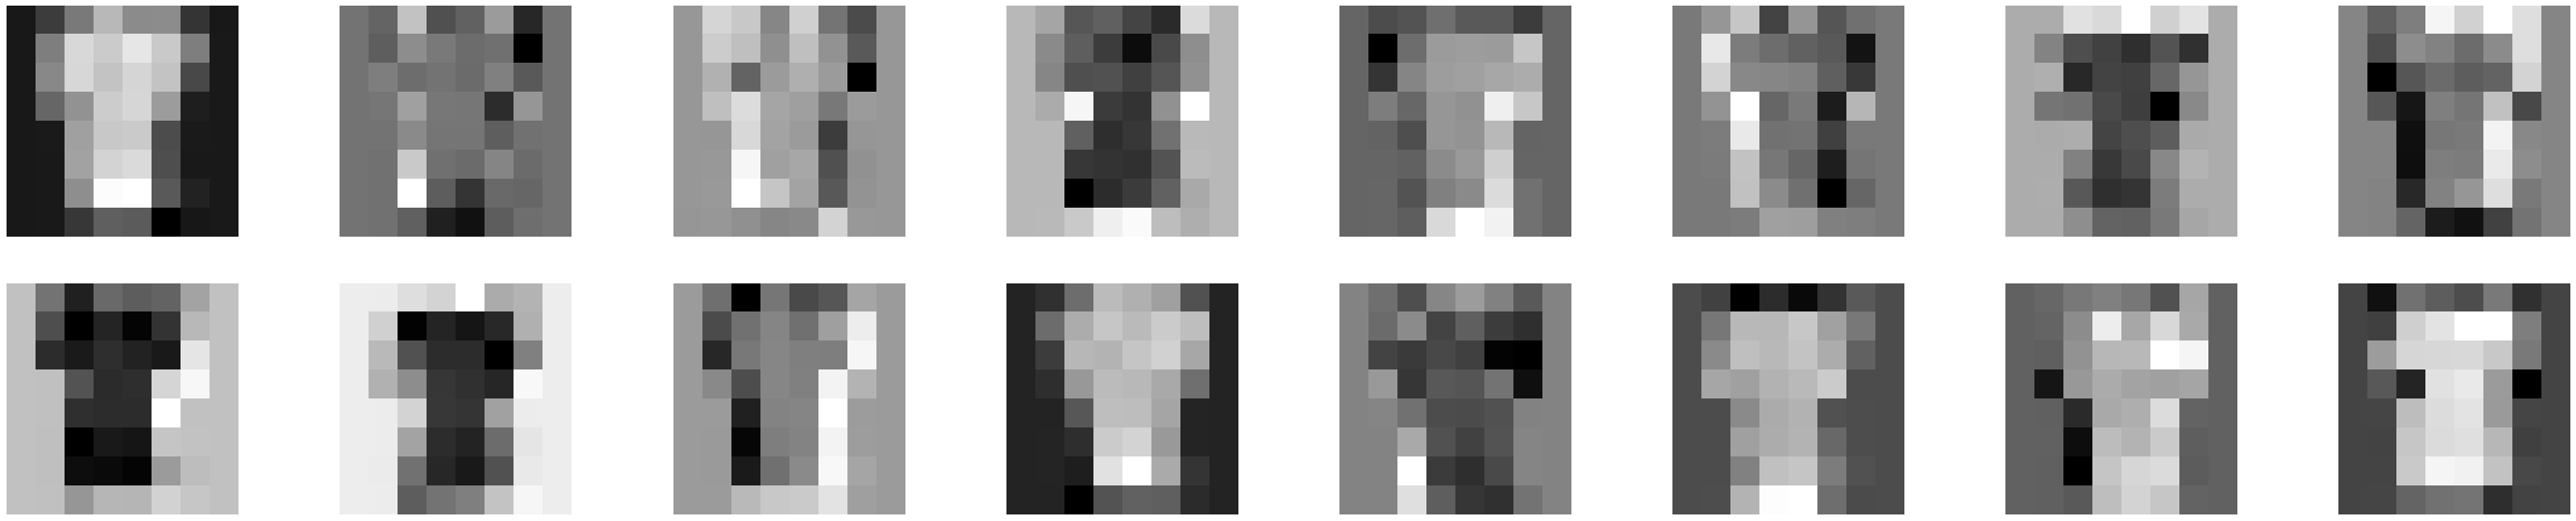

In [105]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

## Weigth visualization

In this section it is possible to visualize the weight for the first layer, since it takes on a single channel. The low dimension of the kernels do not allow further analysis on the kernel functions. 

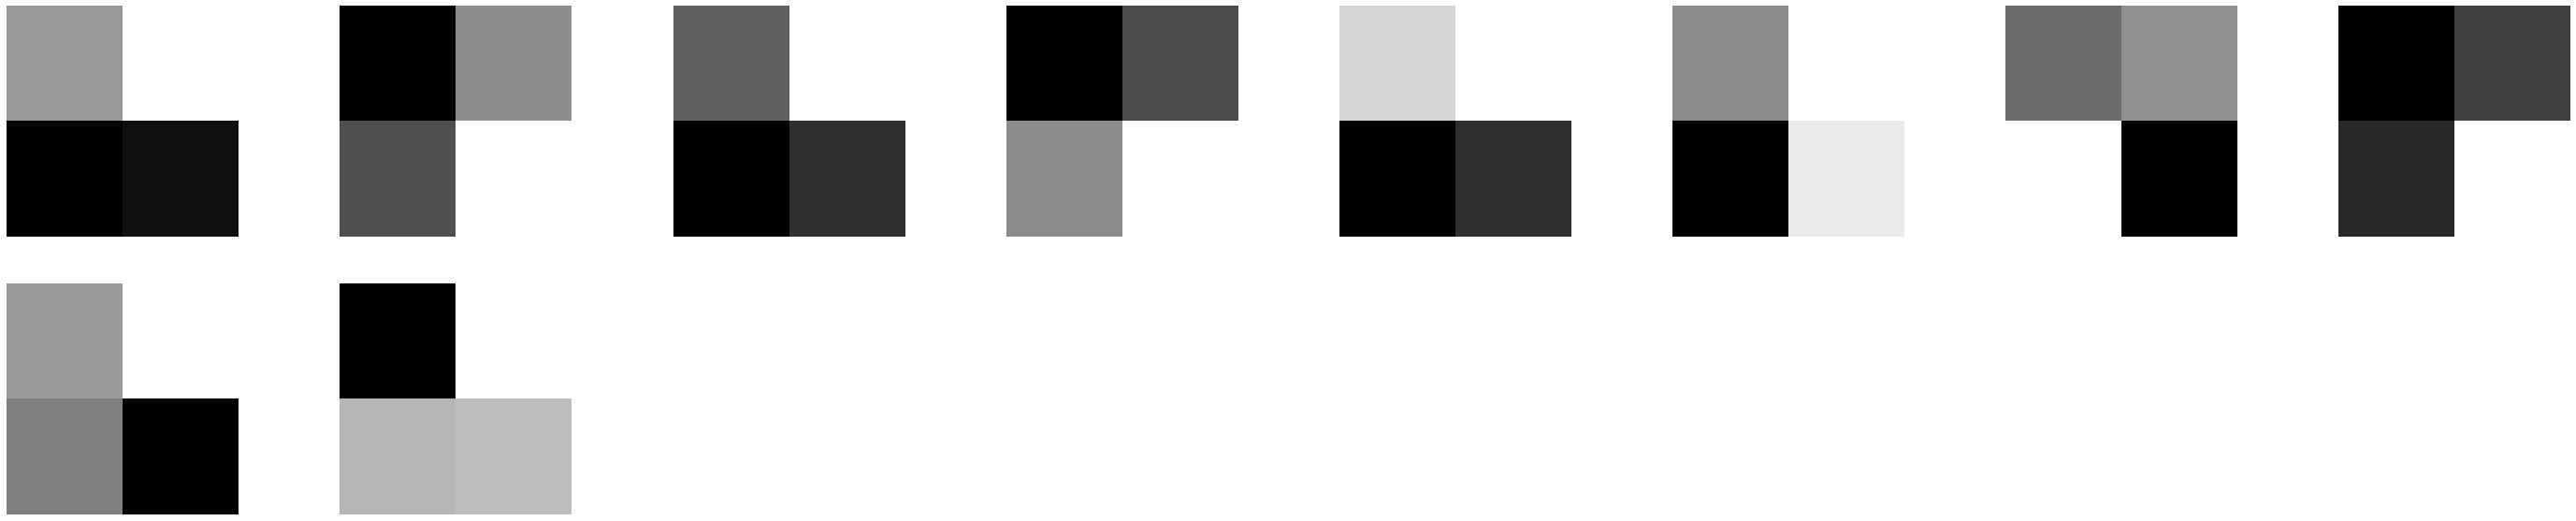

In [106]:
for layer in [conv_layers[0]]:
    plt.figure(figsize=(50, 10))
    for i,channel in enumerate(layer.weight.data):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(channel[0], cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()


## Gridsearch

In this section a Gridsearch approach for parameter estimation was applied

In [ ]:
# params = {
#     'lr': np.arange(0.001,0.1,0.009),
#     'batch_size': list(range(100,30000,500)),
#     'module__dropout' : np.arange(0.1,1,0.1),
#     'module__linear_size' : np.arange(1,50,10,dtype=int),
#     'module__conv0_size' : np.arange(1,50,10,dtype=int),
#     'module__conv1_size' : np.arange(1,50,10, dtype=int)
# }

# rs = RandomizedSearchCV(estimator = net_skorch, 
#                    param_distributions = params, 
#                    cv = 5, n_iter = 200)
                   
# rs.fit(input_data, label_data)
# print(rs.best_score_, rs.best_params_)

In [ ]:
df = pd.read_csv("Random_Classification.csv").sort_values("mean_test_score")
df[df["std_test_score"]<0.05].tail(5)

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_module__linear_size,param_module__dropout,param_module__conv1_size,param_module__conv0_size,param_lr,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,30,68.578734,0.166213,0.300303,0.021322,31,0.9,41,11,0.037,5600,"{'module__linear_size': 31, 'module__dropout':...",0.835167,0.763250,0.699417,0.801000,0.775500,0.774867,0.045049,8
92,92,121.948128,0.250700,0.593636,0.022935,41,0.3,41,41,0.010,2600,"{'module__linear_size': 41, 'module__dropout':...",0.823750,0.801833,0.822083,0.750500,0.718667,0.783367,0.041802,6
155,155,41.225464,0.600999,0.238100,0.027135,41,0.1,11,11,0.082,1600,"{'module__linear_size': 41, 'module__dropout':...",0.811417,0.803333,0.814917,0.830167,0.725083,0.796983,0.036989,4
61,61,48.145947,0.086620,0.241600,0.023999,41,0.2,21,11,0.010,3600,"{'module__linear_size': 41, 'module__dropout':...",0.872417,0.811833,0.786083,0.749500,0.791833,0.802333,0.040417,2
26,26,46.225161,0.333087,0.222901,0.022355,11,0.6,21,11,0.073,1600,"{'module__linear_size': 11, 'module__dropout':...",0.801167,0.784500,0.859667,0.863583,0.799833,0.821750,0.033104,1
